<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/05/0514.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random

random.seed(10)
sns.set_theme()

### PCA and eigenvectors - recap

In [2]:
def plot_data_and_axis(data, eigenvectors=None, axis_min=None,
                        axis_max=None, figsize=None):

    """
    This function plots data in a 3D coordinate system.
    This functio also plots coordinate system axis or arbitrary
    set of vectors.

    :param data: numpy dataset with 3 features
    :param eigenvectors: transposed eigenvector matrix
    :param axis_min: min value for each axis on the plot
    :param axis_max: max value for each axis on the plot
    :return:
    """

    # Create 3D figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the data
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.2)

    # Set axis labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Set minimum and maximum value for axis
    if axis_min and axis_max:
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_zlim(axis_min, axis_max)

    ax.view_init(elev=20, azim=-35, roll=0)

    # Choose which axis will be plotted (arrow tips)
    if eigenvectors is not None:
        plot_vectors = eigenvectors
    else:
        plot_vectors = [
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ]

    # Always set the origin at [0,0,0] (arrow starting point)
    origin = [0, 0, 0]

    # Iterate over coordinate system arrows (three of them)
    for i, component in enumerate(plot_vectors):

        # Plot arrow
        ax.quiver(
            origin[0],
            origin[1],
            origin[2],
            component[0],
            component[1],
            component[2],
            color=['r', 'g', 'b'][i],
            lw=2
        )

    plt.show()

In [3]:
# Create 2D normaly distributed data
mean = np.array([0,0])
cov = np.array([[1,0.5],[0.5,1]])

# Create z feature
x_y_data = np.random.multivariate_normal(mean, cov, 500)
z_col = 1.5*x_y_data[:,1]

# Merge z col with x and y
np_data_3D = np.column_stack([x_y_data, z_col])

# Create dataframe in order to display data
df_3D = pd.DataFrame(np_data_3D, columns=['x', 'y', 'z'])
df_3D.head()

,x,y,z
0,-0.881929,-0.380935,-0.571403
1,-1.657538,-1.761210,-2.641816
2,-0.864047,0.352641,0.528961
3,-0.198944,1.073480,1.610219
4,0.807987,-0.334410,-0.501616


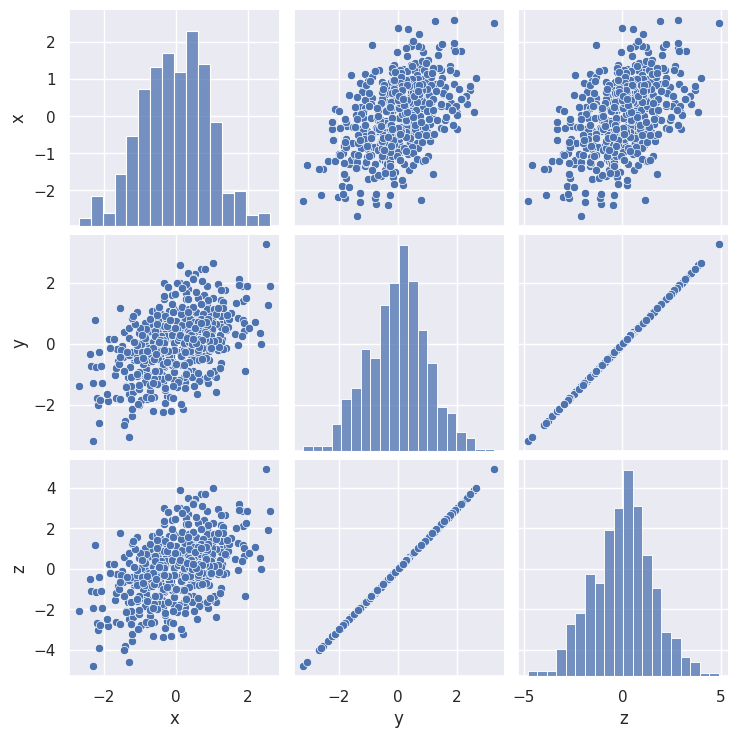

In [4]:
sns.pairplot(df_3D)

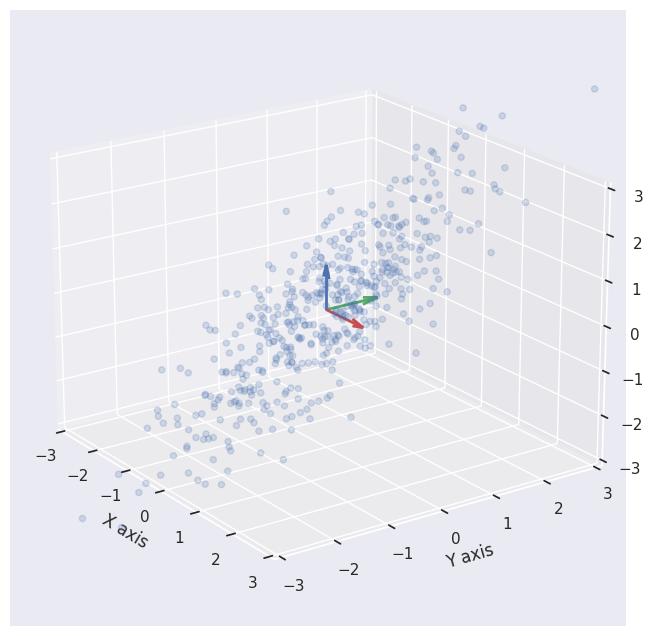

In [5]:
# Plot the data in the original coordinate system
plot_data_and_axis(
    data=np_data_3D,
    axis_min=-3,
    axis_max=3,
    figsize=(8,8)
)

In [6]:
# Calculate the covariance matrixe
cov_mtx = df_3D.cov().to_numpy()
cov_mtx

array([[0.90777792, 0.46708528, 0.70062791],
       [0.46708528, 1.0471243 , 1.57068644],
       [0.70062791, 1.57068644, 2.35602967]])

In [7]:
# Calculate eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_mtx)

In [8]:
eigenvalues

array([ 3.66071460e+00,  6.50217281e-01, -1.84752279e-16])

In [9]:
np.set_printoptions(suppress=True)
eigenvalues / np.sum(eigenvalues)*100

array([84.91701334, 15.08298666, -0.        ])

In [10]:
eigenvectors

array([[-0.29249647, -0.9562666 ,  0.        ],
       [-0.53044127,  0.16224785, -0.83205029],
       [-0.79566191,  0.24337177,  0.5547002 ]])

In [11]:
sort_idx = np.flip(np.argsort(eigenvalues))

eigenvalues = eigenvalues[sort_idx]
eigenvectors = eigenvectors[:, sort_idx]

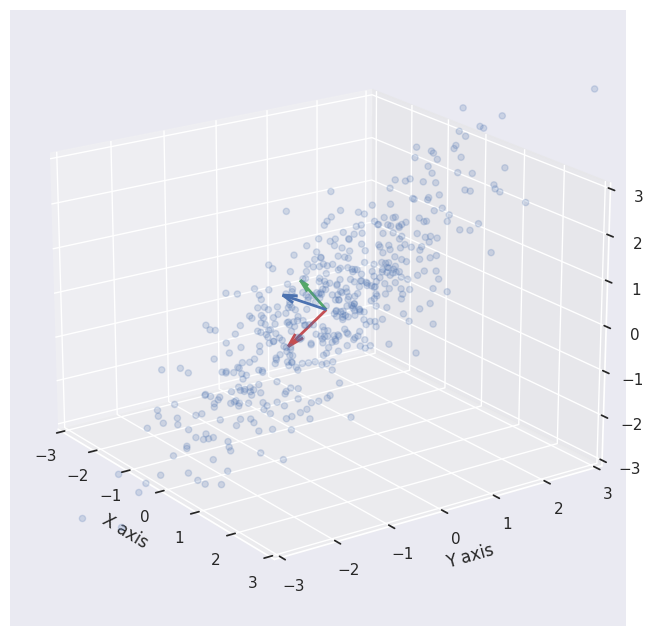

In [12]:
# Plot the data and prinicipal component vectors
plot_data_and_axis(
    data=np_data_3D,
    eigenvectors=eigenvectors.T,
    axis_min=-3,
    axis_max=3,
    figsize=(8,8)
)

In [13]:
# Transform data to 2D
transformation_matrix = eigenvectors[:, :-1].T
transformed_data = transformation_matrix @ df_3D.to_numpy().T

In [14]:
transformed_df = pd.DataFrame(transformed_data.T, columns=['PC1', 'PC2'])

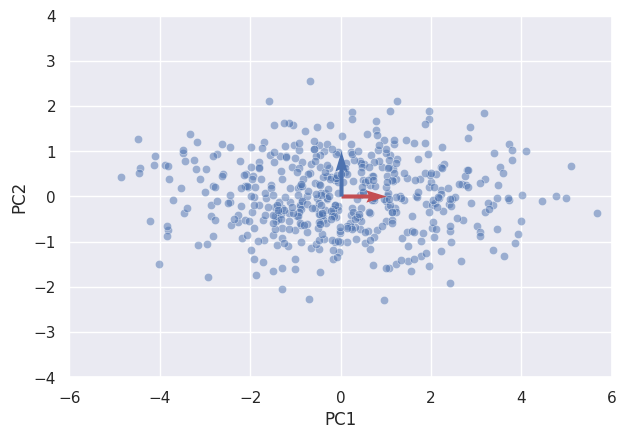

In [15]:
# Plot the reduced data
plt.figure(figsize=(7,7))
sns.scatterplot(transformed_df,x='PC1',y='PC2', alpha=0.5)
plt.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='r', label="PC1 vector")
plt.quiver(0, 0,0, 1, angles='xy', scale_units='xy', scale=1, color='b', label="PC2 vector")
plt.xlim([-6, 6])
plt.ylim([-4, 4])
plt.gca().set_aspect('equal', adjustable='box')

### PCA - sklearn

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(svd_solver='full')
pca = pca.fit(df_3D)

In [18]:
print('sklearn pca {}'.format(pca.explained_variance_ratio_*100))
print('our pca {}'.format(eigenvalues / np.sum(eigenvalues)*100))

sklearn pca [84.91701334 15.08298666  0.        ]
our pca [84.91701334 15.08298666 -0.        ]


In [19]:
pca.explained_variance_ratio_ == (eigenvalues / np.sum(eigenvalues))

array([False, False, False])

In [20]:
print('sklearn transformation matrix \n {}'.format(pca.components_))
print('our transformation matrix \n {}'.format(eigenvectors.T))

sklearn transformation matrix 
 [[ 0.29249647  0.53044127  0.79566191]
 [-0.9562666   0.16224785  0.24337177]
 [ 0.         -0.83205029  0.5547002 ]]
our transformation matrix 
 [[-0.29249647 -0.53044127 -0.79566191]
 [-0.9562666   0.16224785  0.24337177]
 [ 0.         -0.83205029  0.5547002 ]]


In [22]:
pca.components_ = pca.components_[:-1, :]

In [23]:
pca_transform_data = pca.transform(df_3D)

pca_transformed_df = pd.DataFrame(pca_transform_data, columns=['PC1', 'PC2'])

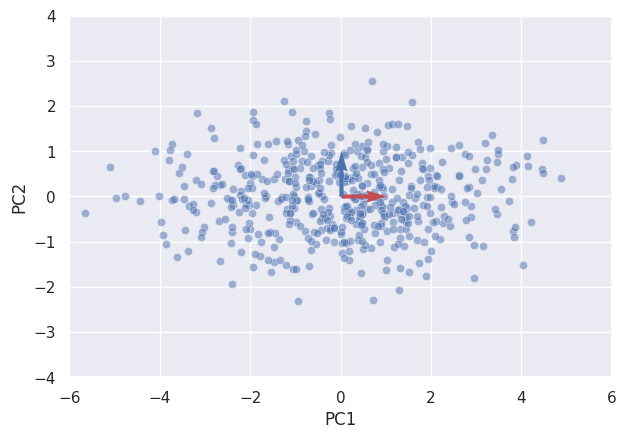

In [24]:
# Plot the reduced data
plt.figure(figsize=(7,7))
sns.scatterplot(pca_transformed_df,x='PC1',y='PC2', alpha=0.5)
plt.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='r', label="PC1 vector")
plt.quiver(0, 0,0, 1, angles='xy', scale_units='xy', scale=1, color='b', label="PC2 vector")
plt.xlim([-6, 6])
plt.ylim([-4, 4])
plt.gca().set_aspect('equal', adjustable='box')